In [2]:
import sys
sys.executable

'/Users/faisal./jupyter_env/bin/python'

#### Baseline evaluation for negation dataset

In [48]:
# for negation dataset
import json
import os

PATH = 'coco_datasets/negation_200'
metadata = os.path.join(PATH,'negation_metadata.json')

prompts = {}

with open(metadata,'r') as f:
    data = json.load(f)
    for i in range(len(data)):
        prompts[data[i]['file_name']] = [data[i]['correct_caption'],data[i]['negated_caption']]
    print([data[i]['image_id'] for i in range(len(data))])

[48564, 353970, 57150, 212072, 398810, 281693, 209747, 541664, 249643, 449406, 156372, 44068, 148739, 138492, 289222, 176446, 18833, 65288, 485844, 76261, 100489, 26465, 129054, 262048, 32901, 269196, 377575, 234607, 357737, 262938, 270677, 361103, 289702, 87875, 355905, 410712, 201676, 283785, 492284, 153782, 121497, 285788, 411665, 136033, 377000, 460929, 527695, 269866, 183049, 73533, 516316, 377393, 217060, 85157, 385719, 151962, 320632, 260266, 281929, 165681, 241297, 376284, 231088, 559513, 132329, 283113, 474854, 534270, 5600, 25603, 455219, 130586, 61471, 215778, 405306, 571008, 261888, 461573, 487583, 480021, 437392, 181499, 152465, 463842, 364557, 81988, 494427, 23023, 365655, 526392, 564280, 540928, 437898, 199551, 476810, 210099, 329323, 360137, 190756, 318908, 365886, 383606, 309938, 242287, 335800, 544605, 214200, 315001, 273711, 290248, 39480, 563603, 514586, 427338, 286458, 55022, 340697, 545826, 498919, 79651, 189078, 577539, 557672, 39769, 86956, 303653, 202001, 15712

In [40]:
import clip
import torch

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")
print("Loading CLIP model")
model, preprocess = clip.load('ViT-B/32', device)

print("Successfully loaded CLIP model")

Using device: mps
Loading CLIP model
Successfully loaded CLIP model


In [49]:
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from tqdm import tqdm

class negationDatasetMake(Dataset):
    def __init__(self, metadata, PATH,preprocess, transform=None, target_transform=None):
        self.preprocess = preprocess
        self.imageDIR = PATH

        with open(metadata,"r") as f:
            self.data = json.load(f)
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        #Gets one sample (one image, its set of prompts, and the correct index)
        sample_data = self.data[idx]
        prompts = [sample_data['correct_caption'],sample_data['negated_caption']]

        image = Image.open(os.path.join(self.imageDIR, sample_data['file_name']))
        image_tensor = self.preprocess(image)
        text_tensor = clip.tokenize(prompts)

        correct_idx = 0

        return image_tensor, text_tensor, correct_idx

In [50]:
BATCH_SIZE = 32
negationDataset = negationDatasetMake(metadata,PATH,preprocess)
dataloader = DataLoader(
    dataset = negationDataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0
)

Starting eval with delta metric...


100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  2.30it/s]


--- Similarity Delta Report ---
Samples evaluated:        200
Accuracy (argmax):        60.00%
Mean delta (logit space): 0.0018
Median delta:             0.0021
Std delta:                0.0057
% delta > 0 (correct > top incorrect): 60.00%
% delta < 0 (confidently wrong):       40.00%
% delta <= 0.01 (tiny margin or worse): 92.50%
% delta >= 0.05: 0.00%, % delta >= 0.1: 0.00%

--- Probability (softmax) summary ---
Mean prob(correct):       0.5063
Mean prob(top incorrect): 0.4937


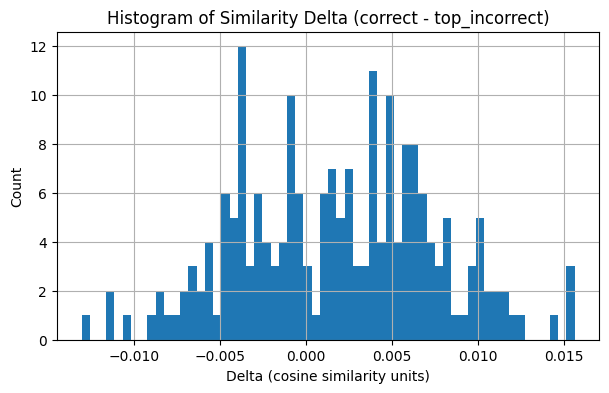

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# CONFIG
BATCH_SIZE = 32
NUM_WORKERS = 0  # use 0 if you're still in notebook; set >0 after moving dataset to a module
TAU = 0.07       # optional: used only if you want probs; delta here is on raw similarity

# storage for diagnostics
all_deltas = []
all_correct_probs = []   # optional: softmax prob assigned to correct choice
all_top_incorrect_probs = []
all_correct_logits = []
all_top_incorrect_logits = []
all_pred_is_correct = []

print("Starting eval with delta metric...")
with torch.no_grad():
    for batch in tqdm(dataloader):   # your dataloader variable
        images, texts, correct_indices = batch
        images = images.to(device)
        texts = texts.to(device)
        correct_indices = correct_indices.to(device)  # shape [B]

        # --- prepare texts (you already do this) ---
        batch_size, num_prompts, seq_len = texts.shape
        texts_reshaped = texts.view(batch_size * num_prompts, seq_len)

        # --- encode ---
        image_features = model.encode_image(images)           # [B, D]
        text_features = model.encode_text(texts_reshaped)    # [B * num_prompts, D]

        # normalize (cosine sims)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features  = text_features  / text_features.norm(dim=-1, keepdim=True)

        # reshape text features to [B, num_prompts, D]
        text_features = text_features.view(batch_size, num_prompts, -1)

        # compute similarity scores [B, num_prompts]
        # image: [B,1,D]  text: [B,D,num_prompts] -> bmm -> [B,1,num_prompts] -> squeeze -> [B,num_prompts]
        scores = torch.bmm(image_features.unsqueeze(1), text_features.transpose(1,2)).squeeze(1)

        # --- Delta calculation (works for MCQ) ---
        # score_correct: [B]
        batch_indices = torch.arange(batch_size, device=device)
        score_correct = scores[batch_indices, correct_indices]                # [B]

        # mask correct positions so they are not considered when taking top incorrect
        # create a mask of shape [B, num_prompts] where True marks the correct index
        correct_mask = torch.zeros_like(scores, dtype=torch.bool, device=device)
        correct_mask[batch_indices, correct_indices] = True

        # set correct positions to -inf so max over dim=1 gives top incorrect
        scores_for_incorrect = scores.masked_fill(correct_mask, float('-inf'))  # [B, num_prompts]
        top_incorrect_scores, _ = scores_for_incorrect.max(dim=1)               # [B]

        # similarity delta per sample
        delta = score_correct - top_incorrect_scores  # [B]  (positive=>correct & margin; negative=>confidently wrong)
        
        # optional: also compute softmax probs (if you want confidence in probability space)
        logits = scores / TAU                     # [B, num_prompts]
        probs = torch.softmax(logits, dim=1)      # [B, num_prompts]
        prob_correct = probs[batch_indices, correct_indices]
        # top incorrect prob:
        probs_for_incorrect = probs.masked_fill(correct_mask, 0.0)
        top_incorrect_prob, _ = probs_for_incorrect.max(dim=1)

        # predictions
        preds = scores.argmax(dim=1)
        is_correct = (preds == correct_indices).cpu().numpy()

        # accumulate (to CPU numpy lists)
        all_deltas.append(delta.cpu().numpy())
        all_correct_probs.append(prob_correct.cpu().numpy())
        all_top_incorrect_probs.append(top_incorrect_prob.cpu().numpy())
        all_correct_logits.append(score_correct.cpu().numpy())
        all_top_incorrect_logits.append(top_incorrect_scores.cpu().numpy())
        all_pred_is_correct.append(is_correct)

# concat arrays
all_deltas = np.concatenate(all_deltas, axis=0)
all_correct_probs = np.concatenate(all_correct_probs, axis=0)
all_top_incorrect_probs = np.concatenate(all_top_incorrect_probs, axis=0)
all_correct_logits = np.concatenate(all_correct_logits, axis=0)
all_top_incorrect_logits = np.concatenate(all_top_incorrect_logits, axis=0)
all_pred_is_correct = np.concatenate(all_pred_is_correct, axis=0)

# --- Summary stats ---
n = all_deltas.size
mean_delta = all_deltas.mean()
median_delta = np.median(all_deltas)
std_delta = all_deltas.std()
pct_positive = (all_deltas > 0).mean() * 100          # % where correct > top incorrect
pct_negative = (all_deltas < 0).mean() * 100
pct_small_margin = (all_deltas <= 0.01).mean() * 100  # tiny margin or worse
pct_gt_0_05 = (all_deltas >= 0.05).mean() * 100
pct_gt_0_1  = (all_deltas >= 0.1).mean() * 100

# accuracy for reference
accuracy = all_pred_is_correct.mean() * 100

print("\n--- Similarity Delta Report ---")
print(f"Samples evaluated:        {n}")
print(f"Accuracy (argmax):        {accuracy:.2f}%")
print(f"Mean delta (logit space): {mean_delta:.4f}")
print(f"Median delta:             {median_delta:.4f}")
print(f"Std delta:                {std_delta:.4f}")
print(f"% delta > 0 (correct > top incorrect): {pct_positive:.2f}%")
print(f"% delta < 0 (confidently wrong):       {pct_negative:.2f}%")
print(f"% delta <= 0.01 (tiny margin or worse): {pct_small_margin:.2f}%")
print(f"% delta >= 0.05: {pct_gt_0_05:.2f}%, % delta >= 0.1: {pct_gt_0_1:.2f}%")

# also report probabilities summary if useful
print("\n--- Probability (softmax) summary ---")
print(f"Mean prob(correct):       {all_correct_probs.mean():.4f}")
print(f"Mean prob(top incorrect): {all_top_incorrect_probs.mean():.4f}")

# --- Optional: histogram of deltas ---
plt.figure(figsize=(7,4))
plt.hist(all_deltas, bins=60)
plt.title("Histogram of Similarity Delta (correct - top_incorrect)")
plt.xlabel("Delta (cosine similarity units)")
plt.ylabel("Count")
plt.grid(True)
plt.show()


#### Baseline Eval for Numeracy dataset

In [56]:
import json 
import os

PATH = "coco_datasets/numeracy_150"
metadata = os.path.join(PATH,"numeracy_metadata_fixed.json")

# to test if json is being read!
with open(metadata, "r") as f:
    data = json.load(f)

In [55]:
import clip
import torch

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")
#install clip from openAI github
print("Loading CLIP model")
model, preprocess = clip.load('ViT-B/32', device)
print("Successfully loaded CLIP model")

Using device: mps
Loading CLIP model
Successfully loaded CLIP model


In [61]:
from torch.utils.data import Dataset,DataLoader
from PIL import Image

class numeracyDatasetMake(Dataset):
    def __init__(self,PATH,preprocess,data):
        self.preprocess = preprocess
        self.imageDir = PATH
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        sample_data = self.data[idx]
        image_tensor = self.preprocess(Image.open(os.path.join(self.imageDir,sample_data['file_name'])))
        prompts = [sample_data["correct_caption"]] + sample_data["foils"]
        text_tensor = clip.tokenize(prompts)

        correct_idx = 0
        return image_tensor, text_tensor, correct_idx
        

In [60]:
BATCH_SIZE = 32
numeracyData = numeracyDatasetMake(PATH,preprocess,data)
numeracyDataloader = DataLoader(
    dataset = numeracyData,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0
)

Starting eval with delta metric...


100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


--- Similarity Delta Report ---
Samples evaluated:        150
Accuracy (argmax):        31.33%
Mean delta (logit space): -0.0017
Median delta:             -0.0015
Std delta:                0.0044
% delta > 0 (correct > top incorrect): 27.33%
% delta < 0 (confidently wrong):       68.67%
% delta <= 0.01 (tiny margin or worse): 98.67%
% delta >= 0.05: 0.00%, % delta >= 0.1: 0.00%

--- Probability (softmax) summary ---
Mean prob(correct):       0.3364
Mean prob(top incorrect): 0.3450


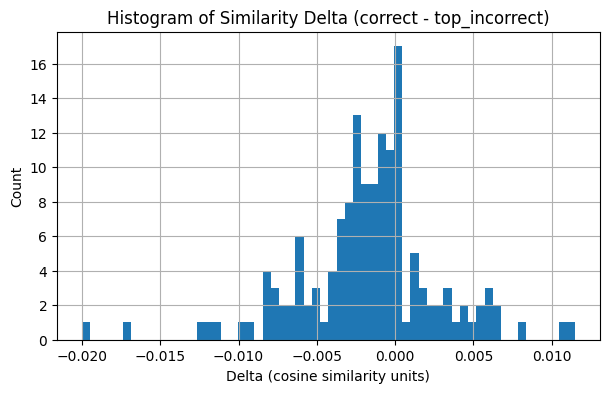

In [62]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# CONFIG
TAU = 0.07       # optional: used only if you want probs; delta here is on raw similarity

# storage for diagnostics
all_deltas = []
all_correct_probs = []   # optional: softmax prob assigned to correct choice
all_top_incorrect_probs = []
all_correct_logits = []
all_top_incorrect_logits = []
all_pred_is_correct = []

print("Starting eval with delta metric...")
with torch.no_grad():
    for batch in tqdm(numeracyDataloader):   # your dataloader variable
        images, texts, correct_indices = batch
        images = images.to(device)
        texts = texts.to(device)
        correct_indices = correct_indices.to(device)  # shape [B]

        # --- prepare texts (you already do this) ---
        batch_size, num_prompts, seq_len = texts.shape
        texts_reshaped = texts.view(batch_size * num_prompts, seq_len)

        # --- encode ---
        image_features = model.encode_image(images)           # [B, D]
        text_features = model.encode_text(texts_reshaped)    # [B * num_prompts, D]

        # normalize (cosine sims)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features  = text_features  / text_features.norm(dim=-1, keepdim=True)

        # reshape text features to [B, num_prompts, D]
        text_features = text_features.view(batch_size, num_prompts, -1)

        # compute similarity scores [B, num_prompts]
        # image: [B,1,D]  text: [B,D,num_prompts] -> bmm -> [B,1,num_prompts] -> squeeze -> [B,num_prompts]
        scores = torch.bmm(image_features.unsqueeze(1), text_features.transpose(1,2)).squeeze(1)

        # --- Delta calculation (works for MCQ) ---
        # score_correct: [B]
        batch_indices = torch.arange(batch_size, device=device)
        score_correct = scores[batch_indices, correct_indices]                # [B]

        # mask correct positions so they are not considered when taking top incorrect
        # create a mask of shape [B, num_prompts] where True marks the correct index
        correct_mask = torch.zeros_like(scores, dtype=torch.bool, device=device)
        correct_mask[batch_indices, correct_indices] = True

        # set correct positions to -inf so max over dim=1 gives top incorrect
        scores_for_incorrect = scores.masked_fill(correct_mask, float('-inf'))  # [B, num_prompts]
        top_incorrect_scores, _ = scores_for_incorrect.max(dim=1)               # [B]

        # similarity delta per sample
        delta = score_correct - top_incorrect_scores  # [B]  (positive=>correct & margin; negative=>confidently wrong)
        
        # optional: also compute softmax probs (if you want confidence in probability space)
        logits = scores / TAU                     # [B, num_prompts]
        probs = torch.softmax(logits, dim=1)      # [B, num_prompts]
        prob_correct = probs[batch_indices, correct_indices]
        # top incorrect prob:
        probs_for_incorrect = probs.masked_fill(correct_mask, 0.0)
        top_incorrect_prob, _ = probs_for_incorrect.max(dim=1)

        # predictions
        preds = scores.argmax(dim=1)
        is_correct = (preds == correct_indices).cpu().numpy()

        # accumulate (to CPU numpy lists)
        all_deltas.append(delta.cpu().numpy())
        all_correct_probs.append(prob_correct.cpu().numpy())
        all_top_incorrect_probs.append(top_incorrect_prob.cpu().numpy())
        all_correct_logits.append(score_correct.cpu().numpy())
        all_top_incorrect_logits.append(top_incorrect_scores.cpu().numpy())
        all_pred_is_correct.append(is_correct)

# concat arrays
all_deltas = np.concatenate(all_deltas, axis=0)
all_correct_probs = np.concatenate(all_correct_probs, axis=0)
all_top_incorrect_probs = np.concatenate(all_top_incorrect_probs, axis=0)
all_correct_logits = np.concatenate(all_correct_logits, axis=0)
all_top_incorrect_logits = np.concatenate(all_top_incorrect_logits, axis=0)
all_pred_is_correct = np.concatenate(all_pred_is_correct, axis=0)

# --- Summary stats ---
n = all_deltas.size
mean_delta = all_deltas.mean()
median_delta = np.median(all_deltas)
std_delta = all_deltas.std()
pct_positive = (all_deltas > 0).mean() * 100          # % where correct > top incorrect
pct_negative = (all_deltas < 0).mean() * 100
pct_small_margin = (all_deltas <= 0.01).mean() * 100  # tiny margin or worse
pct_gt_0_05 = (all_deltas >= 0.05).mean() * 100
pct_gt_0_1  = (all_deltas >= 0.1).mean() * 100

# accuracy for reference
accuracy = all_pred_is_correct.mean() * 100

print("\n--- Similarity Delta Report ---")
print(f"Samples evaluated:        {n}")
print(f"Accuracy (argmax):        {accuracy:.2f}%")
print(f"Mean delta (logit space): {mean_delta:.4f}")
print(f"Median delta:             {median_delta:.4f}")
print(f"Std delta:                {std_delta:.4f}")
print(f"% delta > 0 (correct > top incorrect): {pct_positive:.2f}%")
print(f"% delta < 0 (confidently wrong):       {pct_negative:.2f}%")
print(f"% delta <= 0.01 (tiny margin or worse): {pct_small_margin:.2f}%")
print(f"% delta >= 0.05: {pct_gt_0_05:.2f}%, % delta >= 0.1: {pct_gt_0_1:.2f}%")

# also report probabilities summary if useful
print("\n--- Probability (softmax) summary ---")
print(f"Mean prob(correct):       {all_correct_probs.mean():.4f}")
print(f"Mean prob(top incorrect): {all_top_incorrect_probs.mean():.4f}")

# --- Optional: histogram of deltas ---
plt.figure(figsize=(7,4))
plt.hist(all_deltas, bins=60)
plt.title("Histogram of Similarity Delta (correct - top_incorrect)")
plt.xlabel("Delta (cosine similarity units)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

#### Baseline evaluation for Attribute binding (to check if clip understands object attributes)

In [63]:
import os
import json

PATH = "coco_datasets/attr_binding_dataset"
metadata = os.path.join(PATH,"attributes_metadata.json")

with open(metadata,"r") as f:
    data = json.load(f)

In [65]:
import clip
import torch

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")
#install clip from openAI github
print("Loading CLIP model")
model, preprocess = clip.load('ViT-B/32', device)
print("Successfully loaded CLIP model")

Using device: mps
Loading CLIP model
Successfully loaded CLIP model


In [67]:
from torch.utils.data import Dataset,DataLoader
from PIL import Image

class attributeDatasetMake(Dataset):
    def __init__(self,PATH,preprocess,data):
        self.preprocess = preprocess
        self.imageDir = PATH
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        sample_data = self.data[idx]
        image_tensor = self.preprocess(Image.open(os.path.join(self.imageDir,sample_data['base_image'])))
        prompts = [sample_data["base_caption"],sample_data["swap_caption"]]
        text_tensor = clip.tokenize(prompts)

        correct_idx = 0
        return image_tensor, text_tensor, correct_idx

In [68]:
BATCH_SIZE = 32
attributeData = attributeDatasetMake(PATH,preprocess,data)
attributeDataLoader = DataLoader(
    dataset = attributeData,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0
)

Starting eval with delta metric...


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.71it/s]


--- Similarity Delta Report ---
Samples evaluated:        75
Accuracy (argmax):        58.67%
Mean delta (logit space): 0.0005
Median delta:             0.0000
Std delta:                0.0045
% delta > 0 (correct > top incorrect): 49.33%
% delta < 0 (confidently wrong):       41.33%
% delta <= 0.01 (tiny margin or worse): 97.33%
% delta >= 0.05: 0.00%, % delta >= 0.1: 0.00%

--- Probability (softmax) summary ---
Mean prob(correct):       0.5015
Mean prob(top incorrect): 0.4983


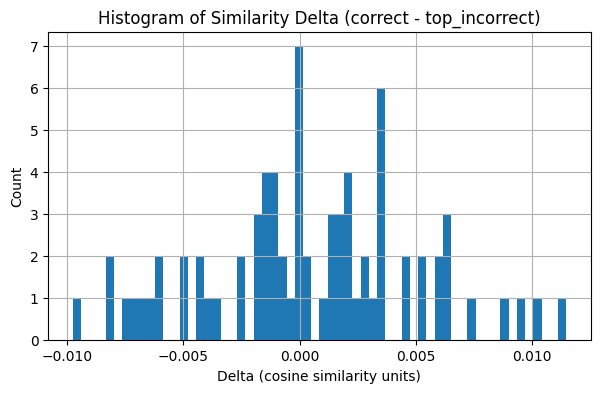

In [69]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# CONFIG
TAU = 0.07       # optional: used only if you want probs; delta here is on raw similarity

# storage for diagnostics
all_deltas = []
all_correct_probs = []   # optional: softmax prob assigned to correct choice
all_top_incorrect_probs = []
all_correct_logits = []
all_top_incorrect_logits = []
all_pred_is_correct = []

print("Starting eval with delta metric...")
with torch.no_grad():
    for batch in tqdm(attributeDataLoader):   # your dataloader variable
        images, texts, correct_indices = batch
        images = images.to(device)
        texts = texts.to(device)
        correct_indices = correct_indices.to(device)  # shape [B]

        # --- prepare texts (you already do this) ---
        batch_size, num_prompts, seq_len = texts.shape
        texts_reshaped = texts.view(batch_size * num_prompts, seq_len)

        # --- encode ---
        image_features = model.encode_image(images)           # [B, D]
        text_features = model.encode_text(texts_reshaped)    # [B * num_prompts, D]

        # normalize (cosine sims)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features  = text_features  / text_features.norm(dim=-1, keepdim=True)

        # reshape text features to [B, num_prompts, D]
        text_features = text_features.view(batch_size, num_prompts, -1)

        # compute similarity scores [B, num_prompts]
        # image: [B,1,D]  text: [B,D,num_prompts] -> bmm -> [B,1,num_prompts] -> squeeze -> [B,num_prompts]
        scores = torch.bmm(image_features.unsqueeze(1), text_features.transpose(1,2)).squeeze(1)

        # --- Delta calculation (works for MCQ) ---
        # score_correct: [B]
        batch_indices = torch.arange(batch_size, device=device)
        score_correct = scores[batch_indices, correct_indices]                # [B]

        # mask correct positions so they are not considered when taking top incorrect
        # create a mask of shape [B, num_prompts] where True marks the correct index
        correct_mask = torch.zeros_like(scores, dtype=torch.bool, device=device)
        correct_mask[batch_indices, correct_indices] = True

        # set correct positions to -inf so max over dim=1 gives top incorrect
        scores_for_incorrect = scores.masked_fill(correct_mask, float('-inf'))  # [B, num_prompts]
        top_incorrect_scores, _ = scores_for_incorrect.max(dim=1)               # [B]

        # similarity delta per sample
        delta = score_correct - top_incorrect_scores  # [B]  (positive=>correct & margin; negative=>confidently wrong)
        
        # optional: also compute softmax probs (if you want confidence in probability space)
        logits = scores / TAU                     # [B, num_prompts]
        probs = torch.softmax(logits, dim=1)      # [B, num_prompts]
        prob_correct = probs[batch_indices, correct_indices]
        # top incorrect prob:
        probs_for_incorrect = probs.masked_fill(correct_mask, 0.0)
        top_incorrect_prob, _ = probs_for_incorrect.max(dim=1)

        # predictions
        preds = scores.argmax(dim=1)
        is_correct = (preds == correct_indices).cpu().numpy()

        # accumulate (to CPU numpy lists)
        all_deltas.append(delta.cpu().numpy())
        all_correct_probs.append(prob_correct.cpu().numpy())
        all_top_incorrect_probs.append(top_incorrect_prob.cpu().numpy())
        all_correct_logits.append(score_correct.cpu().numpy())
        all_top_incorrect_logits.append(top_incorrect_scores.cpu().numpy())
        all_pred_is_correct.append(is_correct)

# concat arrays
all_deltas = np.concatenate(all_deltas, axis=0)
all_correct_probs = np.concatenate(all_correct_probs, axis=0)
all_top_incorrect_probs = np.concatenate(all_top_incorrect_probs, axis=0)
all_correct_logits = np.concatenate(all_correct_logits, axis=0)
all_top_incorrect_logits = np.concatenate(all_top_incorrect_logits, axis=0)
all_pred_is_correct = np.concatenate(all_pred_is_correct, axis=0)

# --- Summary stats ---
n = all_deltas.size
mean_delta = all_deltas.mean()
median_delta = np.median(all_deltas)
std_delta = all_deltas.std()
pct_positive = (all_deltas > 0).mean() * 100          # % where correct > top incorrect
pct_negative = (all_deltas < 0).mean() * 100
pct_small_margin = (all_deltas <= 0.01).mean() * 100  # tiny margin or worse
pct_gt_0_05 = (all_deltas >= 0.05).mean() * 100
pct_gt_0_1  = (all_deltas >= 0.1).mean() * 100

# accuracy for reference
accuracy = all_pred_is_correct.mean() * 100

print("\n--- Similarity Delta Report ---")
print(f"Samples evaluated:        {n}")
print(f"Accuracy (argmax):        {accuracy:.2f}%")
print(f"Mean delta (logit space): {mean_delta:.4f}")
print(f"Median delta:             {median_delta:.4f}")
print(f"Std delta:                {std_delta:.4f}")
print(f"% delta > 0 (correct > top incorrect): {pct_positive:.2f}%")
print(f"% delta < 0 (confidently wrong):       {pct_negative:.2f}%")
print(f"% delta <= 0.01 (tiny margin or worse): {pct_small_margin:.2f}%")
print(f"% delta >= 0.05: {pct_gt_0_05:.2f}%, % delta >= 0.1: {pct_gt_0_1:.2f}%")

# also report probabilities summary if useful
print("\n--- Probability (softmax) summary ---")
print(f"Mean prob(correct):       {all_correct_probs.mean():.4f}")
print(f"Mean prob(top incorrect): {all_top_incorrect_probs.mean():.4f}")

# --- Optional: histogram of deltas ---
plt.figure(figsize=(7,4))
plt.hist(all_deltas, bins=60)
plt.title("Histogram of Similarity Delta (correct - top_incorrect)")
plt.xlabel("Delta (cosine similarity units)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

#### Baseline evaluation on spatial dataset

In [84]:
import os
import json

PATH = "coco_datasets/spatial_mcq_dataset"
metadata = os.path.join(PATH,"spatial_metadata.json")

with open(metadata,"r") as f:
    data = json.load(f)

In [85]:
import clip
import torch

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")
#install clip from openAI github
print("Loading CLIP model")
model, preprocess = clip.load('ViT-B/32', device)
print("Successfully loaded CLIP model")

Using device: mps
Loading CLIP model
Successfully loaded CLIP model


In [86]:
from torch.utils.data import Dataset,DataLoader
from PIL import Image

class spatialDatasetMake(Dataset):
    def __init__(self,PATH,preprocess,data):
        self.preprocess = preprocess
        self.imageDir = PATH
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        sample_data = self.data[idx]
        imageName = sample_data["image"].split("/")[-1]
        image_tensor = self.preprocess(Image.open(os.path.join(self.imageDir,imageName)))
        prompts = sample_data["options"]
        text_tensor = clip.tokenize(prompts)

        correct_idx = sample_data["correct_index"]
        return image_tensor, text_tensor, correct_idx

In [87]:
BATCH_SIZE = 32
spatialData = spatialDatasetMake(PATH,preprocess,data)
spatialDataLoader = DataLoader(
    dataset = spatialData,
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 0
)

Starting eval with delta metric...


100%|███████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]



--- Similarity Delta Report ---
Samples evaluated:        150
Accuracy (argmax):        50.67%
Mean delta (logit space): -0.0000
Median delta:             0.0001
Std delta:                0.0050
% delta > 0 (correct > top incorrect): 50.00%
% delta < 0 (confidently wrong):       47.33%
% delta <= 0.01 (tiny margin or worse): 97.33%
% delta >= 0.05: 0.00%, % delta >= 0.1: 0.00%

--- Probability (softmax) summary ---
Mean prob(correct):       0.5000
Mean prob(top incorrect): 0.5000


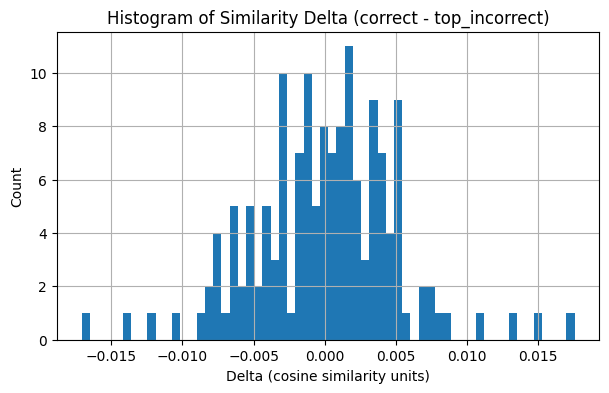

In [88]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# CONFIG
TAU = 0.07       # optional: used only if you want probs; delta here is on raw similarity

# storage for diagnostics
all_deltas = []
all_correct_probs = []   # optional: softmax prob assigned to correct choice
all_top_incorrect_probs = []
all_correct_logits = []
all_top_incorrect_logits = []
all_pred_is_correct = []

print("Starting eval with delta metric...")
with torch.no_grad():
    for batch in tqdm(spatialDataLoader):   # your dataloader variable
        images, texts, correct_indices = batch
        images = images.to(device)
        texts = texts.to(device)
        correct_indices = correct_indices.to(device)  # shape [B]

        # --- prepare texts (you already do this) ---
        batch_size, num_prompts, seq_len = texts.shape
        texts_reshaped = texts.view(batch_size * num_prompts, seq_len)

        # --- encode ---
        image_features = model.encode_image(images)           # [B, D]
        text_features = model.encode_text(texts_reshaped)    # [B * num_prompts, D]

        # normalize (cosine sims)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features  = text_features  / text_features.norm(dim=-1, keepdim=True)

        # reshape text features to [B, num_prompts, D]
        text_features = text_features.view(batch_size, num_prompts, -1)

        # compute similarity scores [B, num_prompts]
        # image: [B,1,D]  text: [B,D,num_prompts] -> bmm -> [B,1,num_prompts] -> squeeze -> [B,num_prompts]
        scores = torch.bmm(image_features.unsqueeze(1), text_features.transpose(1,2)).squeeze(1)

        # --- Delta calculation (works for MCQ) ---
        # score_correct: [B]
        batch_indices = torch.arange(batch_size, device=device)
        score_correct = scores[batch_indices, correct_indices]                # [B]

        # mask correct positions so they are not considered when taking top incorrect
        # create a mask of shape [B, num_prompts] where True marks the correct index
        correct_mask = torch.zeros_like(scores, dtype=torch.bool, device=device)
        correct_mask[batch_indices, correct_indices] = True

        # set correct positions to -inf so max over dim=1 gives top incorrect
        scores_for_incorrect = scores.masked_fill(correct_mask, float('-inf'))  # [B, num_prompts]
        top_incorrect_scores, _ = scores_for_incorrect.max(dim=1)               # [B]

        # similarity delta per sample
        delta = score_correct - top_incorrect_scores  # [B]  (positive=>correct & margin; negative=>confidently wrong)
        
        # optional: also compute softmax probs (if you want confidence in probability space)
        logits = scores / TAU                     # [B, num_prompts]
        probs = torch.softmax(logits, dim=1)      # [B, num_prompts]
        prob_correct = probs[batch_indices, correct_indices]
        # top incorrect prob:
        probs_for_incorrect = probs.masked_fill(correct_mask, 0.0)
        top_incorrect_prob, _ = probs_for_incorrect.max(dim=1)

        # predictions
        preds = scores.argmax(dim=1)
        is_correct = (preds == correct_indices).cpu().numpy()

        # accumulate (to CPU numpy lists)
        all_deltas.append(delta.cpu().numpy())
        all_correct_probs.append(prob_correct.cpu().numpy())
        all_top_incorrect_probs.append(top_incorrect_prob.cpu().numpy())
        all_correct_logits.append(score_correct.cpu().numpy())
        all_top_incorrect_logits.append(top_incorrect_scores.cpu().numpy())
        all_pred_is_correct.append(is_correct)

# concat arrays
all_deltas = np.concatenate(all_deltas, axis=0)
all_correct_probs = np.concatenate(all_correct_probs, axis=0)
all_top_incorrect_probs = np.concatenate(all_top_incorrect_probs, axis=0)
all_correct_logits = np.concatenate(all_correct_logits, axis=0)
all_top_incorrect_logits = np.concatenate(all_top_incorrect_logits, axis=0)
all_pred_is_correct = np.concatenate(all_pred_is_correct, axis=0)

# --- Summary stats ---
n = all_deltas.size
mean_delta = all_deltas.mean()
median_delta = np.median(all_deltas)
std_delta = all_deltas.std()
pct_positive = (all_deltas > 0).mean() * 100          # % where correct > top incorrect
pct_negative = (all_deltas < 0).mean() * 100
pct_small_margin = (all_deltas <= 0.01).mean() * 100  # tiny margin or worse
pct_gt_0_05 = (all_deltas >= 0.05).mean() * 100
pct_gt_0_1  = (all_deltas >= 0.1).mean() * 100

# accuracy for reference
accuracy = all_pred_is_correct.mean() * 100

print("\n--- Similarity Delta Report ---")
print(f"Samples evaluated:        {n}")
print(f"Accuracy (argmax):        {accuracy:.2f}%")
print(f"Mean delta (logit space): {mean_delta:.4f}")
print(f"Median delta:             {median_delta:.4f}")
print(f"Std delta:                {std_delta:.4f}")
print(f"% delta > 0 (correct > top incorrect): {pct_positive:.2f}%")
print(f"% delta < 0 (confidently wrong):       {pct_negative:.2f}%")
print(f"% delta <= 0.01 (tiny margin or worse): {pct_small_margin:.2f}%")
print(f"% delta >= 0.05: {pct_gt_0_05:.2f}%, % delta >= 0.1: {pct_gt_0_1:.2f}%")

# also report probabilities summary if useful
print("\n--- Probability (softmax) summary ---")
print(f"Mean prob(correct):       {all_correct_probs.mean():.4f}")
print(f"Mean prob(top incorrect): {all_top_incorrect_probs.mean():.4f}")

# --- Optional: histogram of deltas ---
plt.figure(figsize=(7,4))
plt.hist(all_deltas, bins=60)
plt.title("Histogram of Similarity Delta (correct - top_incorrect)")
plt.xlabel("Delta (cosine similarity units)")
plt.ylabel("Count")
plt.grid(True)
plt.show()